In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


In [59]:
# Load the datasets

properties_2016 = pd.read_csv('Downloads/newproperties_2016.csv', low_memory=False)

# Calculate the threshold for dropping columns
threshold = 0.8 * len(properties_2016)

# Drop columns with more than 80% null values
properties_2016 = properties_2016.dropna(axis=1, thresh=threshold)

train_2016 = pd.read_csv('Downloads/train_2016_v2.csv', low_memory=False)

# Merge the datasets
df_train = train_2016.merge(properties_2016, how='left', on='parcelid')

# Display the number of rows in the DataFrame
num_rows = df_train.shape[0]
print(f"The DataFrame has {num_rows} rows.")

print(df_train.columns.tolist())


The DataFrame has 90275 rows.
['parcelid', 'logerror', 'transactiondate', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertycountylandusecode', 'propertylandusetypeid', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock']


In [60]:



# Select numeric and categorical columns
numeric_features = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features.remove('logerror')  # Remove target column
categorical_features = df_train.select_dtypes(include=['object', 'bool']).columns.tolist()

# Convert boolean columns to strings
for col in categorical_features:
    df_train[col] = df_train[col].astype(str)

# Reduce the dataset size
df_train_sample = df_train

# Split the data into features and target
X = df_train_sample.drop(columns=['logerror'])
y = df_train_sample['logerror']

In [61]:

# Preprocessing for numeric data: impute missing values and scale
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing for categorical data: impute missing values and encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Preprocess the data
X_processed = preprocessor.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


Train MAE: 0.03049562378842426
Test MAE: 0.07730106092495154
Train MSE: 0.004486471179275824
Test MSE: 0.0283859084871933
Train R2: 0.8268709792190517
Test R2: -0.08865516688436581


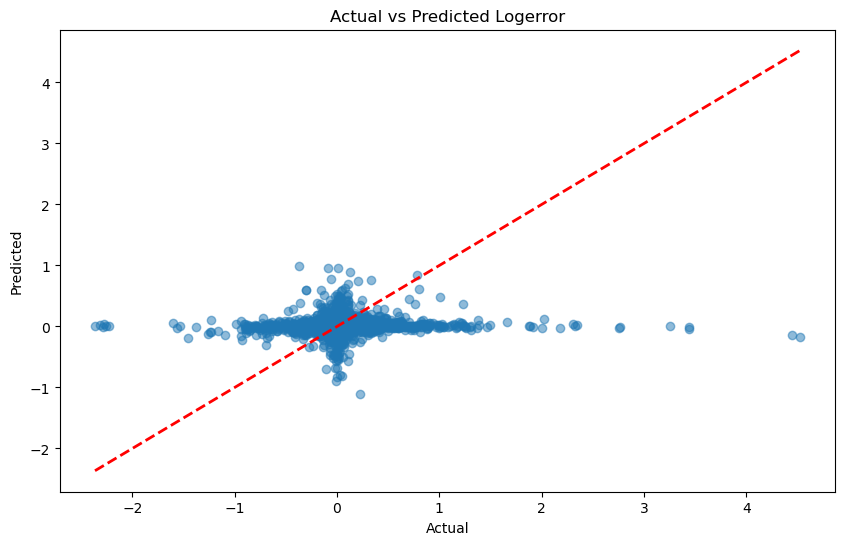

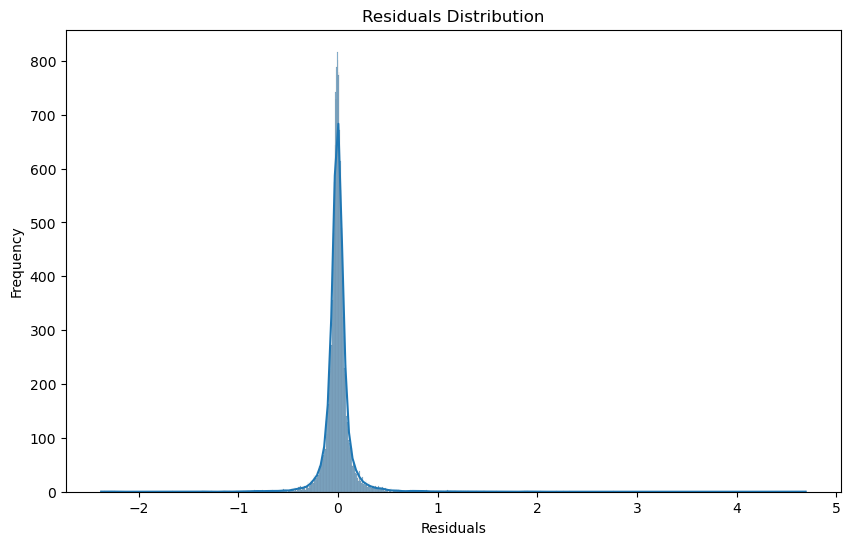

In [86]:


# Initialize the model
model = RandomForestRegressor(n_estimators=20, random_state=42)  # Use fewer estimators for faster processing

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate average logerror for predicted and actual values
avg_predicted_logerror = y_pred_test.mean()
avg_actual_logerror = y_test.mean()

# Evaluate the model
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"Train MAE: {mae_train}")
print(f"Test MAE: {mae_test}")
print(f"Train MSE: {mse_train}")
print(f"Test MSE: {mse_test}")
print(f"Train R2: {r2_train}")
print(f"Test R2: {r2_test}")

# Scatter plot of actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Logerror')
plt.show()

# Residual plot
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


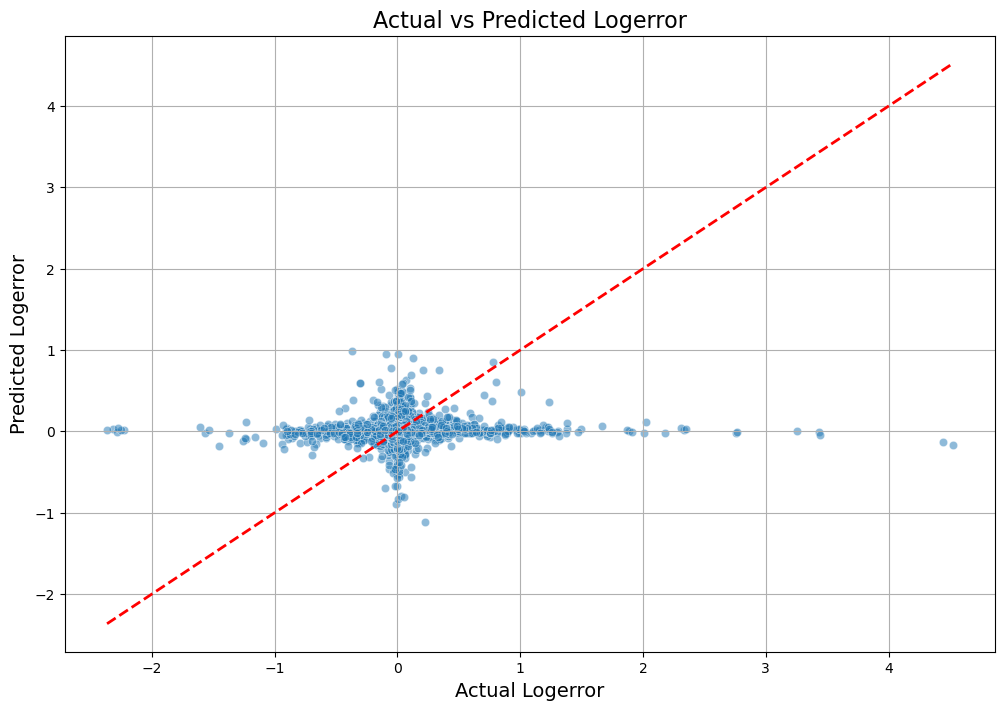

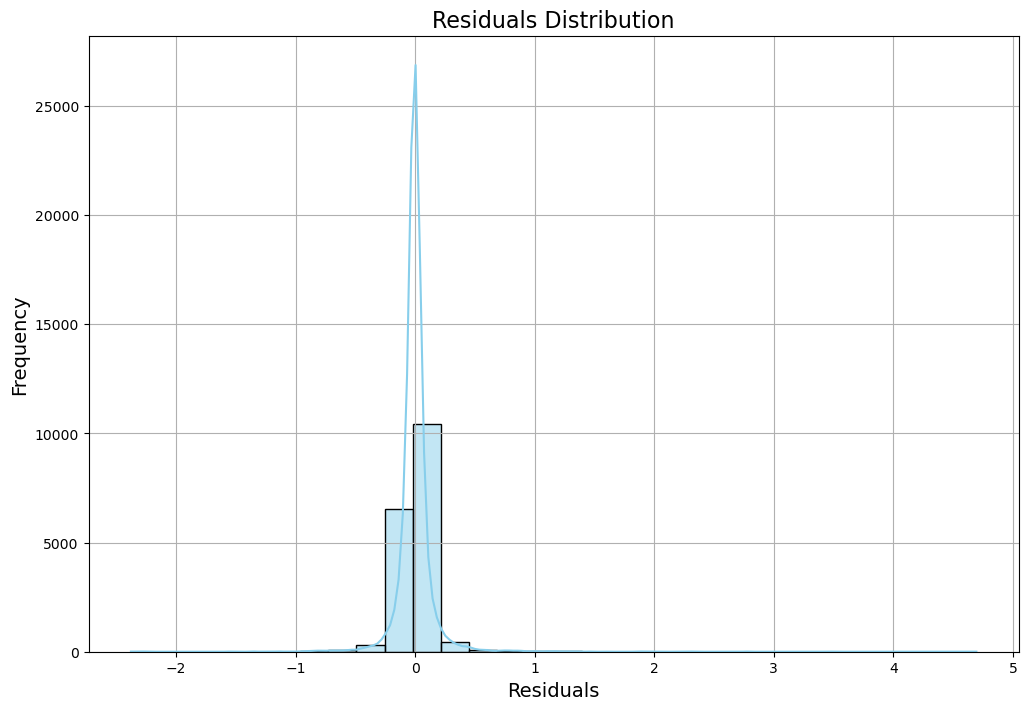

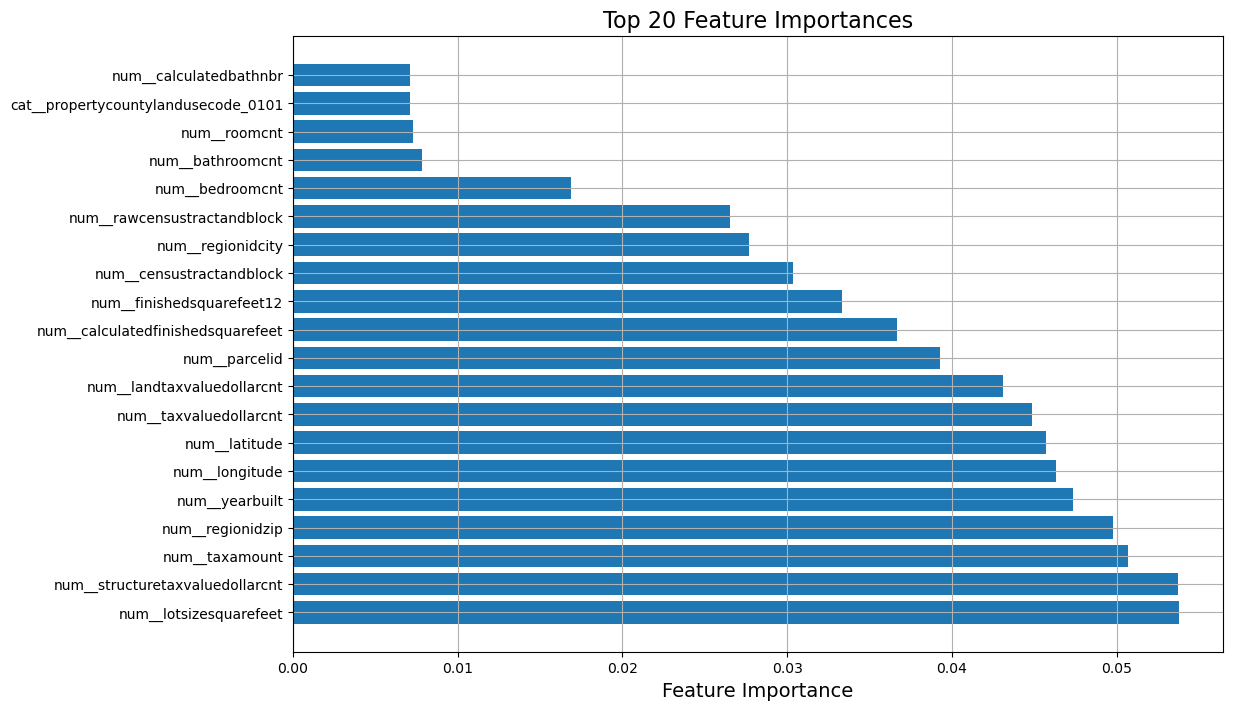

In [87]:
# Scatter plot of actual vs predicted values
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred_test, alpha=0.5, edgecolors='w', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Logerror', fontsize=14)
plt.ylabel('Predicted Logerror', fontsize=14)
plt.title('Actual vs Predicted Logerror', fontsize=16)
plt.grid(True)
plt.show()

# Residual plot
residuals = y_test - y_pred_test
plt.figure(figsize=(12, 8))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Residuals Distribution', fontsize=16)
plt.grid(True)
plt.show()

# Feature importance plot
importances = model.feature_importances_
features = preprocessor.get_feature_names_out()
sorted_indices = importances.argsort()[::-1]
top_indices = sorted_indices[:20]  # Top 20 features

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_indices)), importances[top_indices], align='center')
plt.yticks(range(len(top_indices)), [features[i] for i in top_indices])
plt.xlabel('Feature Importance', fontsize=14)
plt.title('Top 20 Feature Importances', fontsize=16)
plt.grid(True)
plt.show()

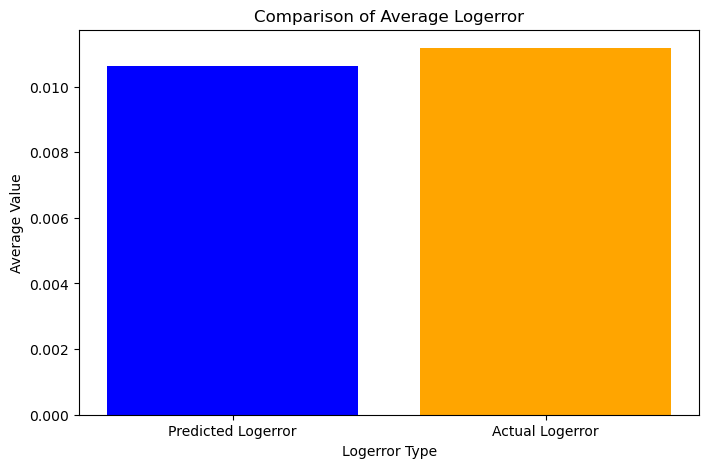

-4.959327817542842
0.010622467737468845 0.011176759900304626


In [92]:
# Optional: Plot comparison of average logerror
plt.figure(figsize=(8, 5))
plt.bar(['Predicted Logerror', 'Actual Logerror'], [avg_predicted_logerror, avg_actual_logerror], color=['blue', 'orange'])
plt.xlabel('Logerror Type')
plt.ylabel('Average Value')
plt.title('Comparison of Average Logerror')
plt.show()
# Calculate the percentage difference
print(((avg_predicted_logerror - avg_actual_logerror)/avg_actual_logerror)*100)
print(avg_predicted_logerror, avg_actual_logerror)

In [100]:


# Initialize and train the Linear Regression model
modellinreg = LinearRegression()
modellinreg.fit(X_train, y_train)

# Make predictions
y_pred_trainlinreg = modellinreg.predict(X_train)
y_pred_testlinreg = modellinreg.predict(X_test)

avg_predicted_logerrorlinreg = y_pred_testlinreg.mean()
avg_actual_logerrorlinreg = y_test.mean()




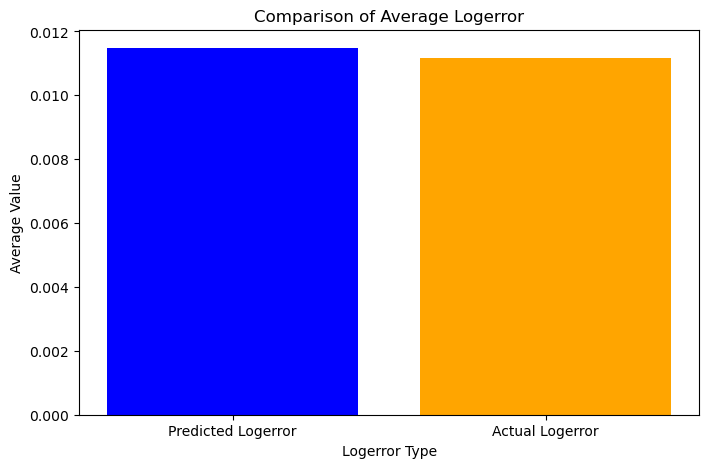

In [101]:
# Optional: Plot comparison of average logerror
plt.figure(figsize=(8, 5))
plt.bar(['Predicted Logerror', 'Actual Logerror'], [avg_predicted_logerrorlinreg, avg_actual_logerrorlinreg], color=['blue', 'orange'])
plt.xlabel('Logerror Type')
plt.ylabel('Average Value')
plt.title('Comparison of Average Logerror')
plt.show()

In [103]:
# Calculate the percentage difference
print(((avg_predicted_logerrorlinreg - avg_actual_logerrorlinreg)/avg_actual_logerrorlinreg)*100)

2.699623101830997
